In [11]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt
import h5py
import os
import numpy as np
from preprocessor import _patchSampler, _patchExtractor
import re
import SimpleITK as sitk
from pylab import *

channels = 6
outputDir = 'PATCHES' #patch file location

folds = 5

# which patients to run on
subjectIDs = [1]
# trainingIDs = [3,5,6,7,9,11,13,14,15,18,19,20]
# valIDs =[8, 12, 16, 1]
# testIDs = [2, 4, 10, 17]

# trainingIDsall = np.random.choice(subjectIDs, (12,), replace=False)
# # valIDs = np.random.choice(trainingIDs, (4,), replace=False)
# testIDs = np.empty(3,)
# count = 0
# temp = trainingIDsall

# for i in subjectIDs:
#     if i not in temp:
# #         print(i)
#         testIDs[count] = i
#         count += 1
# #     elif i in valIDs:
# #         trainingIDs = np.delete(trainingIDs, np.where(trainingIDs==i))
        
# # test = subjectIDs[!trainingIDs]
# print('training patients', trainingIDsall)
# # print('val patients', valIDs)
# print('test patients',testIDs)
testimages, testlbls, acc_folds, val_acc_folds = [],[],[],[]
# trainingimages, traininglbls, testimages, testlbls, valimages, vallbls, acc_folds, val_acc_folds = [],[],[],[],[],[],[],[]
pSize = 29

#create test patches for specified 4 patients in createpatches

In [14]:
folds = 1 # for hold-out validation
for i in range(0, folds):
    batch_size = 128
    num_classes = 3
    epochs = 100
    # print(epochs)
#     trainingIDs = trainingIDsall
#     valIDs = np.random.choice(trainingIDs, (3,), replace=False)
#     for i in subjectIDs:
#         if i in valIDs:
#             trainingIDs = np.delete(trainingIDs, np.where(trainingIDs==i))
    trainingimages, traininglbls, valimages, vallbls = [],[],[],[]
    for subjectID in subjectIDs:
#         if subjectID in trainingIDs:
            #read training file
            outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
            with h5py.File(outputFile,'r') as patchFile:
                trainingimages.append(patchFile['data'][()])
                print(size(trainingimages))
                x = 0
                # plt.imshow(images[x,:,:],interpolation="nearest", cmap = 'gray')
                traininglbls.append(patchFile['labels'][()])
                print(patchFile.get('labels'))
#         elif subjectID in valIDs:
            #read training file for validation set
            outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
            with h5py.File(outputFile,'r') as patchFile:
                valimages.append(patchFile['data'][()])
                x = 0
                # plt.imshow(images[x,:,:],interpolation="nearest", cmap = 'gray')
                vallbls.append(patchFile['labels'][()])
                print(patchFile.get('labels'))
    print(size(trainingimages))
#     break
    img_x, img_y = pSize, pSize;
    x_train = np.array(trainingimages[0])
    y_train = np.array(traininglbls[0])
    x_val, y_val = np.array(trainingimages[0]),np.array(traininglbls[0])

#     for ID in trainingimages[1:]:
#         x_train = np.concatenate([x_train, ID])
#     for ID in traininglbls[1:]:
#         y_train = np.concatenate([y_train, ID])

#     for ID in valimages[1:]:
#         x_val = np.concatenate([x_val, ID])
#     for ID in vallbls[1:]:
#         y_val = np.concatenate([y_val, ID])
    #         else:
    #             x_val = np.concatenate([x_val, ID])
    #             y_val = np.concatenate([y_val, traininglbls[index]])
    #             print(x_val.shape)

    #     print(imarr.shape)
    # x_train, x_test = np.array(trainingimages), np.array()
    # y_train, y_test = np.array(traininglbls), np.array(lbls[-1])
    # x_train, x_test = np.array(trainingimages), np.array(testimages)
    # y_train, y_test = np.array(traininglbls), np.array(testlbls)
    # x_train, x_test = imarr, testimarr
    # y_train, y_test = lblarr, testlblarr

    print(x_train.shape)

    # reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
#     x_train = x_train.reshape(x_train.shape[0], channel, img_x, img_y)
#     x_val = x_val.reshape(x_val.shape[0], channels, img_x, img_y,)
    input_shape = (channels, img_x, img_y)

    # convert the data to the right type
    x_train = x_train.astype('float32')
    x_val = x_val.astype('float32')
#     x_train /= 255
#     x_val /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_val.shape[0], 'val samples')

    # convert class vectors to binary class matrices - this is for use in the
    # categorical_crossentropy loss below
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    # for x_train, y_train in kfold.split(x_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                     activation='relu',
                     input_shape=input_shape,
                     data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     data_format='channels_first'))
    model.add(Conv2D(64, (5, 5), activation='relu',
                     data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),
                     data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    #default: keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(lr=0.0001,decay=0.000),
                  metrics=['accuracy'])
    #run and track accuracy in training and validation
    class AccuracyHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.acc = []

        def on_epoch_end(self, batch, logs={}):
            self.acc.append(logs.get('acc'))
            #print(self.acc)

    hist = AccuracyHistory()

    history = model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),shuffle=True,
                  callbacks=[hist])

    acc_folds.append(history.history['acc'])
    val_acc_folds.append(history.history['val_acc'])

    # history = model.fit(x_train, y_train,
    #               batch_size=batch_size,
    #               epochs=epochs,
    #               verbose=1,
    #               validation_split=0.2,
    #               callbacks=[hist])

5046000
<HDF5 dataset "labels": shape (1000,), type "|u1">
<HDF5 dataset "labels": shape (1000,), type "|u1">
5046000
(1000, 6, 29, 29)
x_train shape: (1000, 6, 29, 29)
1000 train samples
1000 val samples
Train on 1000 samples, validate on 1000 samples
Epoch 1/100


KeyboardInterrupt: 

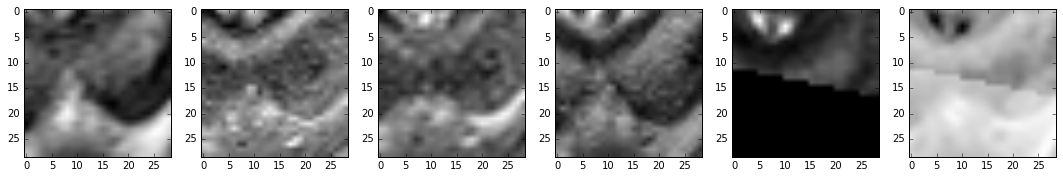

In [15]:
# x_train = np.array(trainingimages[0])
# y_train = np.array(traininglbls[0])
%matplotlib inline
fig,ax = plt.subplots(1,6)
fig.set_size_inches(18.5, 10.5)
islice = 192
ax[0].imshow(x_train[islice,0,:,:], cmap='gray')
ax[1].imshow(x_train[islice,1,:,:], cmap='gray')
ax[2].imshow(x_train[islice,2,:,:], cmap='gray')
ax[3].imshow(x_train[islice,3,:,:], cmap='gray')
ax[4].imshow(x_train[islice,4,:,:], cmap='gray')
ax[5].imshow(x_train[islice,5,:,:], cmap='gray')

In [10]:
#generate predictions
predict = model.predict(x_train, batch_size=1)
# print(predict)
predictmax = []
for pred in predict:
#     val, idx = max(pred);
    predictmax.append(np.argmax(pred))
# predictmax = amax(predict[])
# print(predictmax)

In [4]:
#save hdf5 file of predictions
import datetime #to put date in filename
outputDir = 'CNN_PREDICTIONS'
datestring = str(datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
outputFile = '%s/'%(outputDir) + datestring + 'Fold%d_Patches%d.hdf5'%(folds, pSize)
print('creating '+outputFile)
if not os.path.isdir(outputDir):
    os.makedirs(outputDir)
with h5py.File(outputFile,'w') as outFile:
    #create field indicating original dimensions
            _datashape = shape(predictmax)
            predictions = outFile.create_dataset('predictions', data = predictmax, shape=_datashape, compression="gzip")
            
#             _labelshape = [npatch]
#             labels = patchFile.create_dataset('labels', shape=_labelshape,dtype='uint8')

creating CNN_PREDICTIONS/20170719144113Fold1_Patches29.hdf5


In [44]:
# plot summary

#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.plot(acc_folds)
# plt.plot(val_acc_folds)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

(46072, 29, 29, 6)


In [14]:
#testing

#TODO run one 2D slice 
#TODO add image dimensions as field in hdf5

for subjectID in testIDs:
    #read test file
    outputFile = '%s/patient%s_testPatches%d.hdf5'%(outputDir, int(subjectID), pSize)
    with h5py.File(outputFile,'r') as patchFile:
        testimages.append(patchFile['data'][()])
        x = 0
        # plt.imshow(images[x,:,:],interpolation="nearest", cmap = 'gray')
        testlbls.append(patchFile['labels'][()])
#             print(patchFile.get('labels')) #why subject ID 5, 6, or 7?
x_test = np.array(testimages[0])
y_test = np.array(testlbls[0])

for ID in testimages[1:]:
    x_test = np.concatenate([x_test, ID])
for ID in testlbls[1:]:
    y_test = np.concatenate([y_test, ID])

x_test = x_test.reshape(x_test.shape[0], img_x, img_y, channels)
x_test = x_test.astype('float32')
x_test /= 255
print(x_test.shape[0], 'test samples')

y_test = keras.utils.to_categorical(y_test, num_classes)

#run on test data (unbalanced)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#accuracy
# plt.plot(range(1, 11), history.acc)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.show()

#new accuracy
# print(history.history.keys())

KeyboardInterrupt: 

In [20]:
print(patchFile['labels'])

ValueError: Not a location (Invalid object id)

In [ ]:
#testing
dataDir = '../../MSpatientdata'
for subjectID in testIDs:
    #read test file
    outputFile = '%s/patient%s_testPatches%d.hdf5'%(outputDir, int(subjectID), pSize)
    with h5py.File(outputFile,'r') as patchFile:
        bSize = 1000
        N = patchFile.get('labels').shape[0]
        data = patchFile.get('data')
        p_labels = np.array([0]*N)
        for ibatch in range(0,N,bSize):
            #generate predictions
            predict = model.predict(data[ibatch:min(ibatch+bSize,N),:], batch_size=1) # TODO check
            # print(predict)
            predictmax = []
            for pred in predict:
            #     val, idx = max(pred);
                predictmax.append(np.argmax(pred))
            #predicted_label = np.array([0]*bSize)
            #for i in range(bSize):#if categorical segmentation, not probability, needed
            #    predicted_label[i] = out['prob'][i].argmax(0)
            p_labels[ibatch:min(ibatch+bSize,N)] = predicted_label[:min(ibatch+bSize,N)-ibatch]
        srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'brainmask')
        inputImage = sitk.ReadImage(srcFile)
        mask = sitk.GetArrayFromImage(inputImage)>0
        seg = zeros(mask.shape)
        seg[mask] = p_labels

In [ ]:
outputFile = '%s/patient%s_testPatches%d.hdf5'%(outputDir, int(subjectID), pSize)
with h5py.File(outputFile,'r') as patchFile:
    shape = patchFile.get('data').shape
    print(shape)
    shape = patchFile.get('labels').shape[0]
    print(shape)
    data = patchFile['data'][100000:1002000]
    print(data.shape)
    %matplotlib inline
    fig,ax = plt.subplots(1,6)
    fig.set_size_inches(18.5, 10.5)
    islice = 100
    ax[0].imshow(data[islice,0,:,:], cmap='gray')
    ax[1].imshow(data[islice,1,:,:], cmap='gray')
    ax[2].imshow(data[islice,2,:,:], cmap='gray')
    ax[3].imshow(data[islice,3,:,:], cmap='gray')
    ax[4].imshow(data[islice,4,:,:], cmap='gray')
    ax[5].imshow(data[islice,5,:,:], cmap='gray')

In [3]:
outputFile = '%s/patient%s_trainingPatches%d.hdf5'%(outputDir, subjectID, pSize)
with h5py.File(outputFile,'r') as patchFile:
    trainingimages.append(patchFile['data'][()])
    print(size(trainingimages))

10


In [26]:
dataDir = '../../MSpatientdata'
srcFile = '%s/patient%d/patient%d_%s.nii.gz'%(dataDir, subjectID, subjectID, 'brainmask')
inputImage = sitk.ReadImage(srcFile)
mask = sitk.GetArrayFromImage(inputImage)>0
seg = zeros(mask.shape)
seg[mask] = 1

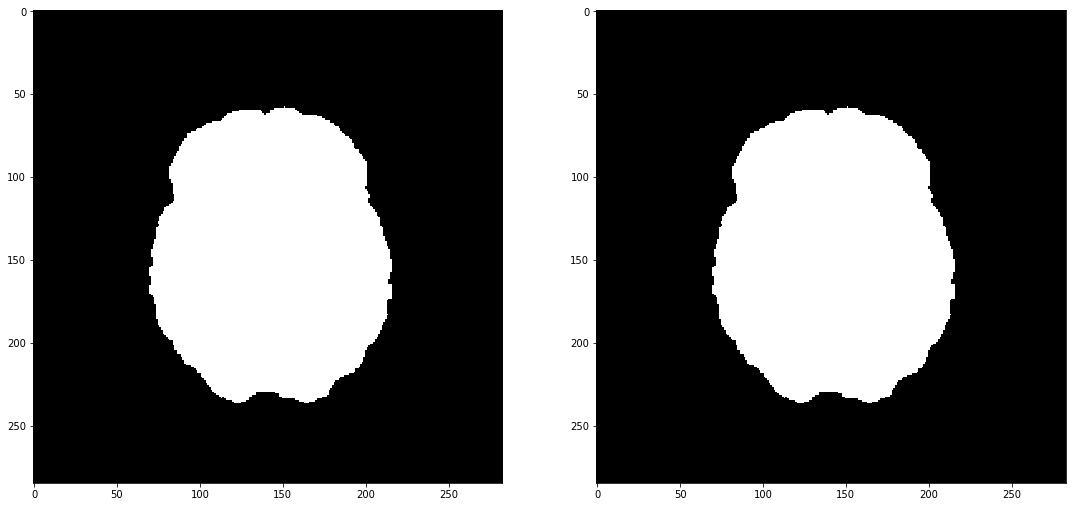

In [31]:
%matplotlib inline
fig,ax = plt.subplots(1,2)
fig.set_size_inches(18.5, 10.5)
islice = 30
ax[0].imshow(seg[islice,:,:], cmap='gray')
ax[1].imshow(mask[islice,:,:], cmap='gray')